# The Price Of Gold

In this blog, my objective is to explain the price of gold based on the following macroeconomic indicators: 

Label: 
- Gold price

Features:
- Federal Reserve Balance Sheet 
- US Treasury 30Y Real Yield
- S&P 500 Index

In [14]:
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-dark-palette')

import PyDSWS as PyDSWS
ds = PyDSWS.Datastream(username='x', password='x')

df = ds.get_data(tickers='USRAC.N, TRUSI30, GOLDBLN, S&PCOMP, NDXYSPT',
                  start="2003-01-01",end="0", freq="D")

df.columns= ['fedbs', 'us30yreal','gold','SP500',' usdollarindex']

In [15]:
df = df.ffill().dropna()
df

,fedbs,us30yreal,gold,SP500,usdollarindex
Date,,,,,
2002-12-31,689052.0,2.616,343.25,879.82,101.85
2003-01-01,689052.0,2.701,344.50,909.03,102.98
2003-01-02,689052.0,2.701,346.75,908.59,102.47
2003-01-05,689052.0,2.738,352.50,929.01,101.97
2003-01-06,689052.0,2.747,349.00,922.93,102.57
...,...,...,...,...,...
2020-07-29,6916542.0,-0.414,1940.10,3246.22,93.02
2020-07-30,6916542.0,-0.455,1975.10,3271.12,93.35
2020-08-02,6916542.0,-0.440,1973.74,3294.61,93.54


# Correlation

In [16]:
df.corr().round(2)[2:3]

,fedbs,us30yreal,gold,SP500,usdollarindex
gold,0.77,-0.82,1.0,0.53,-0.04


# Linear Regression

In [17]:
import statsmodels.formula.api as smf  
linmodel = smf.ols('gold ~ fedbs + us30yreal + SP500', data = df).fit()
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   gold   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     4463.
Date:                Thu, 06 Aug 2020   Prob (F-statistic):               0.00
Time:                        10:27:13   Log-Likelihood:                -31084.
No. Observations:                4591   AIC:                         6.218e+04
Df Residuals:                    4587   BIC:                         6.220e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1650.1397     22.997     71.754      0.000    1605.054    1695.225
fedbs          0.0001   4.07e-06     34.141      0.000       0.000       0.000
us30yreal   -379.0317      8.051    -47.076      0.000    -394.816    -363.247
SP500         -0.2346      0.008    -28.961      0.000      -0.251      -0.219
==============================================================================
Omnibus:                      320.516   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.820
Skew:                           0.122   Prob(JB):                     9.58e-27
Kurtosis:                       2.247   Cond. No.                     2.43e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
df['linear_prediction'] = linmodel.predict(df)
df[['gold','linear_prediction']].round(3)

,gold,linear_prediction
Date,,
2002-12-31,343.25,547.924
2003-01-01,344.50,508.852
2003-01-02,346.75,508.955
2003-01-05,352.50,490.140
2003-01-06,349.00,488.155
...,...,...
2020-07-29,1940.10,2006.718
2020-07-30,1975.10,2016.416
2020-08-02,1973.74,2005.219


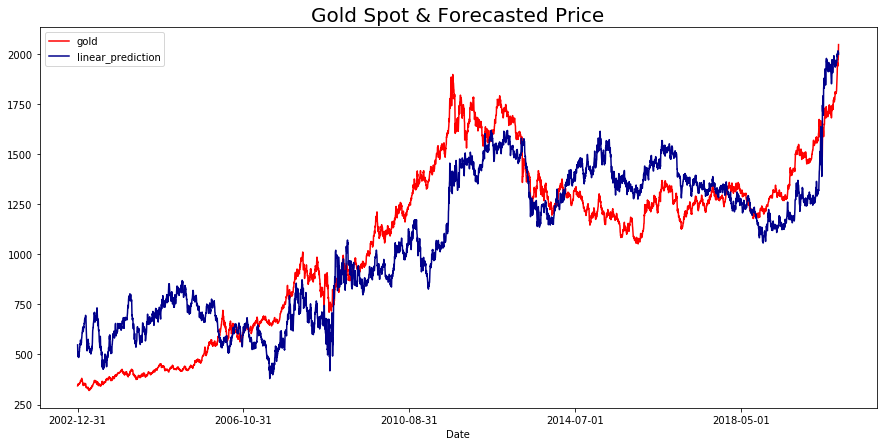

In [19]:
fig = plt.figure(figsize=(15,7))

plt.title('Gold Spot & Forecasted Price',size=20)

df['gold'].plot(color ='red', legend='gold')
df['linear_prediction'].plot(color ='darkblue',legend='linear_prediction');

# Gold Volatility

In [37]:
import eikon as tr
tr.set_app_key('x')
df, e= tr.get_data(['.GVZ','GLD'],['tr.priceclose.date','tr.priceclose'],{'SDate':'2020-06-01','EDate':'0','Frq':'D'})

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) 
df.index = df.index.map(lambda t: t.strftime('%Y-%m-%d'))
df.columns = map(str.lower, df.columns)
df.rename(columns = {'price close':'priceclose'},inplace=True)

In [38]:
df = df.drop_duplicates()
df = df.pivot(columns='instrument', values=['priceclose'])
df['gld'] = df['priceclose']['GLD']
df['volg'] = df['priceclose']['.GVZ']
df['posnegvol%chg'] = ((df['volg']-df['volg'].shift(1))/df['volg'])*100
df['updown'] = np.where(df['gld']>df['gld'].shift(1), 1,0)
df.tail()

priceclose             gld   volg posnegvol%chg updown
instrument       .GVZ     GLD                                    
Date                                                             
2020-07-30      24.13  183.76  183.76  24.13    -11.023622      0
2020-07-31      24.46  185.43  185.43  24.46      1.349141      1
2020-08-03      23.56  185.64  185.64  23.56     -3.820034      1
2020-08-04      26.30  189.59  189.59  26.30     10.418251      1
2020-08-05      25.69  191.35  191.35  25.69     -2.374465      1

In [39]:
df.groupby(['updown']).mean().round(2)

priceclose             gld   volg posnegvol%chg
instrument       .GVZ     GLD                             
updown                                                    
0               19.04  165.51  165.51  19.04         -1.54
1               20.16  171.87  171.87  20.16          1.42

Good luck with the market!

Guillaume Girard, CMT

Fierce Research